#Mental Health Exploring
https://www.kaggle.com/competitions/playground-series-s4e11/overview

In [ ]:
!pip install CATBoost
!pip install optuna

#Create the training and test dataset

---



In [1]:
#1. Download the data from kaggle
import pandas as pd
url ="https://github.com/alamurm/pixelTest/blob/main/case_study/MentalHealthExploring/Dataset"
dsTrain = pd.read_csv( url + "/train.csv?raw=True")
dsTest=pd.read_csv(url+"/test.csv?raw=True")

#EDA - Exploratory Data Analysis

---



In [ ]:
#2. Exploratory data analysis
dsTrain.info()
TARGET = 'Depression'

#Find the features with missing values
print(dsTrain.isnull().sum())

#Analyse the values in the demographics features
print (dsTrain['Age'].value_counts())
print(dsTrain['City'].value_counts())
print(dsTrain['Gender'].value_counts())
print(dsTrain['Profession'].value_counts())
print(dsTrain['Working Professional or Student'].value_counts())

#Aanlayse the values in psychosocial features
print(dsTrain['Financial Stress'].value_counts())
print(dsTrain['Job Satisfaction'].value_counts())
print(dsTrain['Study Satisfaction'].value_counts())
print(dsTrain['Academic Pressure'].value_counts())
print(dsTrain['Work Pressure'].value_counts())
print(dsTrain['Family History of Mental Illness'].value_counts())
print(dsTrain['Have you ever had suicidal thoughts ?'].value_counts())
#Analyse the lifestyle features
print(dsTrain['Sleep Duration'].value_counts())
print(dsTrain['Dietary Habits'].value_counts())
print(dsTrain['Degree'].value_counts())
print(dsTrain['CGPA'].value_counts())
print(dsTrain['Work/Study Hours'].value_counts())

#Analyse age group in order with suicidal thoughts and depression
res = dsTrain[dsTrain['Have you ever had suicidal thoughts ?']=='Yes'].groupby(by = ['Age'])
print(res['Age'].value_counts().sort_values(ascending=False))

#Analyse the class imbalance
classCount= dsTrain['Depression'].value_counts()
print(f'class imbalance ratio , majority over minority class : {round(classCount[0]/classCount[1],2)} : 1')
classCount.to_frame().T

print(dsTrain[dsTrain['Job Satisfaction'].notnull() &
        dsTrain['Study Satisfaction'].notnull()])

# F14 No merging conflicts with the pressure columns
dsTrain[dsTrain['Academic Pressure'].notnull() &
        dsTrain['Work Pressure'].notnull()]


Findings from EDA
1. Id , name column seems irrelevant for our analysis
2. There are around 98 cities 64 professions with high cardinality  features
3. pressure & satisfaction cols has scale from 1 to 5
4. Sleep duration, Dietary habits, Degree has noise
5. Age group with higher risk , 18 - 32!!!
6. job satisfaction and work satisfaction  could be merged
7. Academic pressure and work pressure could be merged
8. There is no class imbalance as the the ratio is 1:4.5 for the target feature , Depression


In [ ]:
#Intialize Variables
CAT_FEATURES=['Gender', 'City', 'Working Professional or Student', 'Profession',
            'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
              'Family History of Mental Illness', 'Academic Pressure', 'Work Pressure',
              'Study Satisfaction','Job Satisfaction', 'Financial Stress']
NUM_FEATURES=['Age', 'CGPA','Work/Study Hours']

FEATURES_WITH_MORE_UNIQUE_VALUES =[]
FEATURES_WITH_LESS_UNIQUE_VALUES =[]
for col in CAT_FEATURES:
    if (len(dsTrain[col].unique()) > 6 ):
      FEATURES_WITH_MORE_UNIQUE_VALUES.append(col)
    else :
      FEATURES_WITH_LESS_UNIQUE_VALUES.append(col)
print(FEATURES_WITH_MORE_UNIQUE_VALUES)
print(FEATURES_WITH_LESS_UNIQUE_VALUES)

#Hanlde noises in the data
DIETARY_HABITS=['Healthy','Moderate','Unhealthy']


#Visual Insights

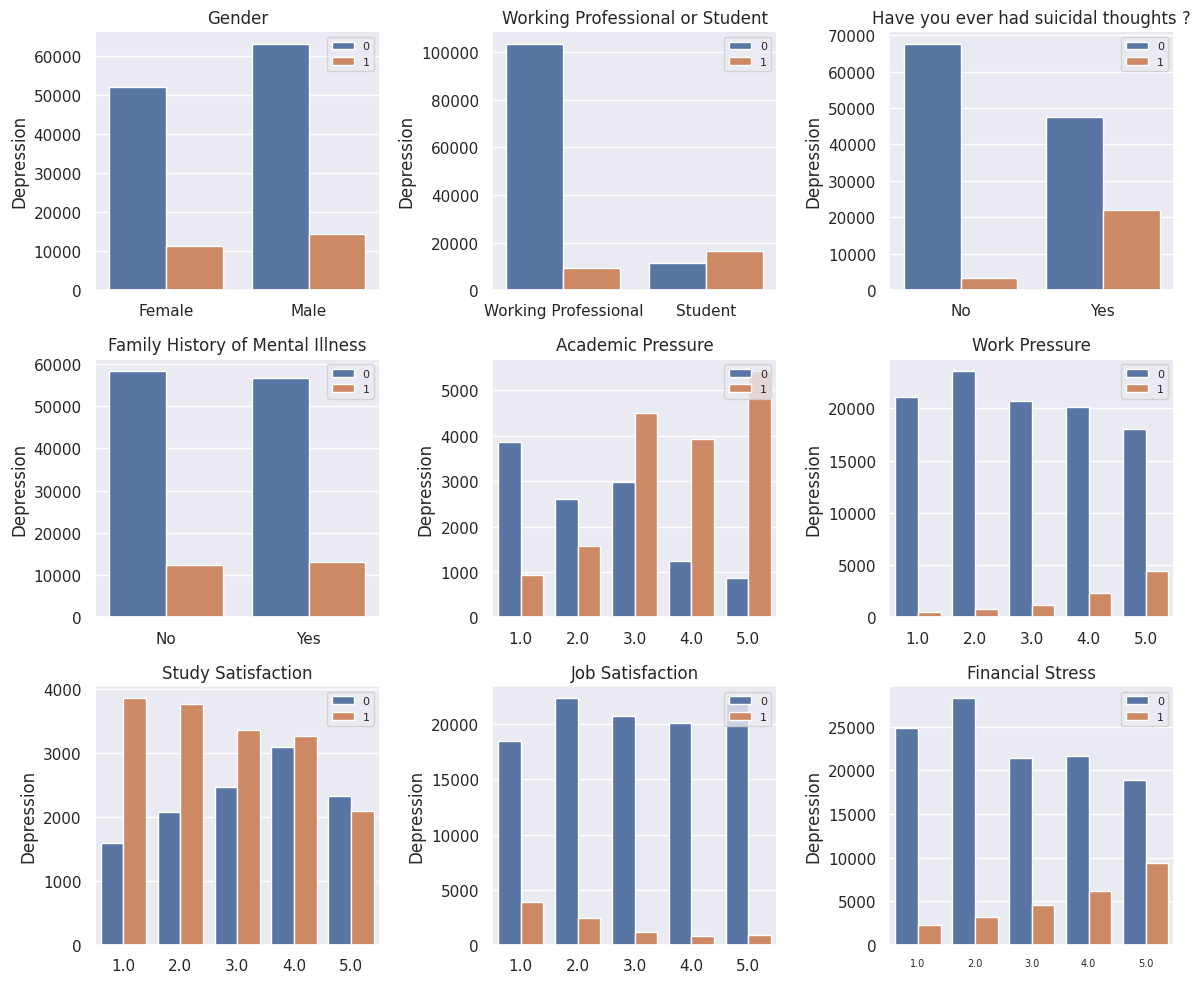

In [4]:
#2 Visual insights
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()
fig, ax =plt.subplots(3,3, figsize=(12,10))
fig.subplots_adjust(wspace=0.3, hspace=0.7)
#Columns to analyse for visual insights

for col, subplot in zip(FEATURES_WITH_LESS_UNIQUE_VALUES, ax.flatten()):

  sns.countplot(ax=subplot, data =dsTrain, x=col, hue='Depression')
  subplot.legend(loc=1, prop={'size': 8})
  subplot.title.set_text(col )
  subplot.set_ylabel(TARGET)
  subplot.set_xlabel('')
  plt.xticks(fontsize=7)

plt.tight_layout()
plt.show()


Visual insights contd...


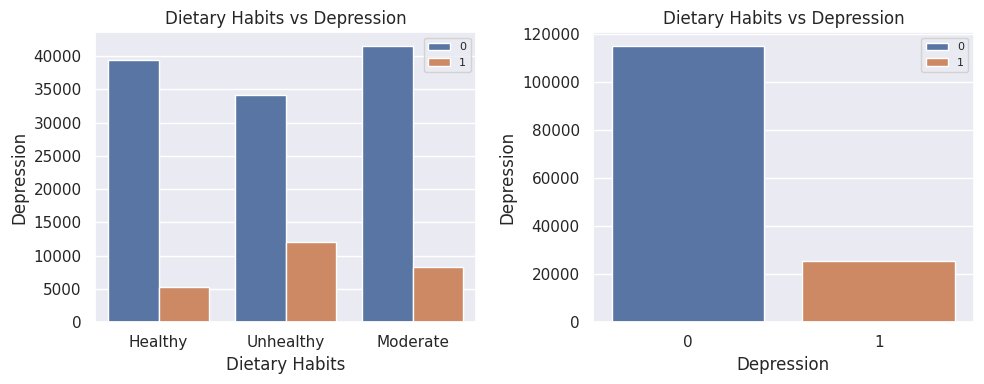

[Text(0, 0, '0'), Text(1, 0, '1')]
Empty DataFrame
Columns: [id, Name, Gender, Age, City, Working Professional or Student, Profession, Academic Pressure, Work Pressure, CGPA, Study Satisfaction, Job Satisfaction, Sleep Duration, Dietary Habits, Degree, Have you ever had suicidal thoughts ?, Work/Study Hours, Financial Stress, Family History of Mental Illness, Depression]
Index: []


In [8]:
filteredData = dsTrain.loc[dsTrain['Dietary Habits'].isin(DIETARY_HABITS)]
fig, ax =plt.subplots(1,2, figsize=(10,4))
#ig.subplots_adjust(wspace=0.3, hspace=0.7)
#Columns to analyse for visual insights
#for col, subplot in zip(FEATURES_WITH_MORE_UNIQUE_VALUES, ax.flatten()):
fig.subplots_adjust(wspace=2.0)
subplot = sns.countplot( ax= ax[0],data=filteredData, x='Dietary Habits', hue='Depression')
subplot.legend(loc=1, prop={'size': 8})
subplot.title.set_text('Dietary Habits' + ' vs ' + TARGET)
subplot.set_ylabel(TARGET)

subplot = sns.countplot( ax= ax[1],data=filteredData, x=TARGET, hue='Depression')
subplot.legend(loc=1, prop={'size': 8})
subplot.title.set_text('Dietary Habits' + ' vs ' + TARGET)
subplot.set_ylabel(TARGET)

plt.tight_layout()
plt.show()

print(subplot.get_xticklabels())
print(filteredData[filteredData['Dietary Habits']=='Yes'])

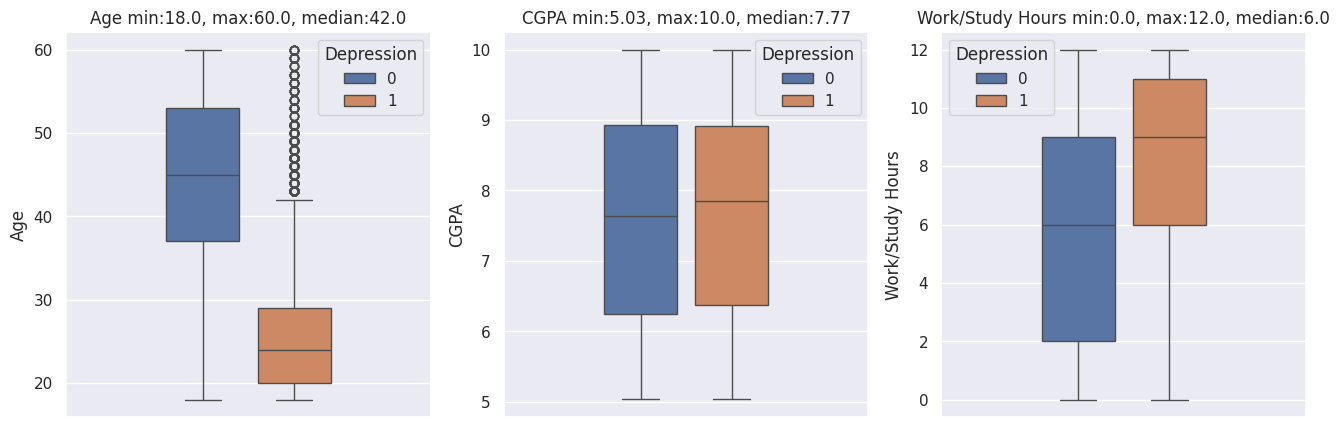

In [9]:
#Box plots for numerical features in realtion to the target
fig, ax =plt.subplots(1,3, figsize=(16,5))

for col, subplot in zip(NUM_FEATURES, ax.flatten()):
  sns.boxplot(data=dsTrain,y= col , hue = TARGET, ax=subplot, width=0.5, gap=0.2)
  subplot.set_title(f'{col} min:{dsTrain[col].min()}, max:{dsTrain[col].max()}, median:{dsTrain[col].median()}')

plt.show()

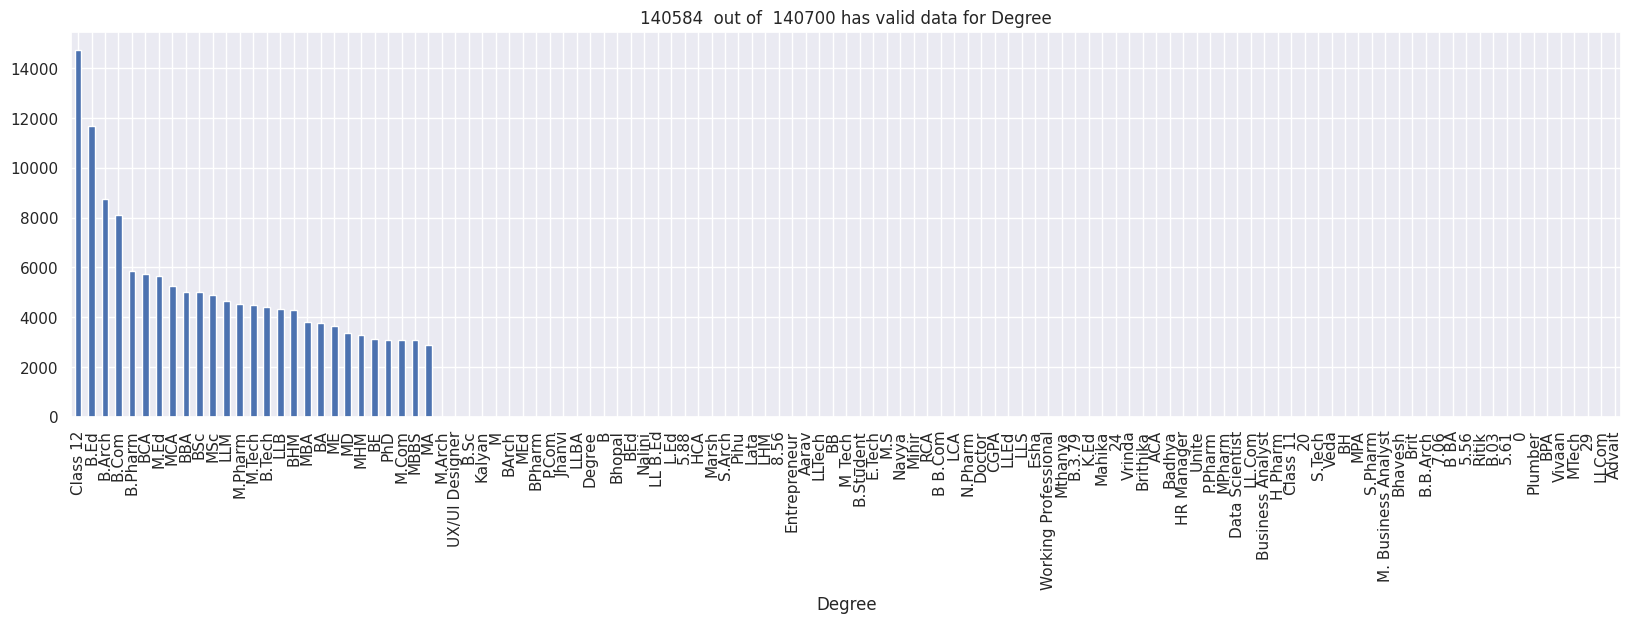

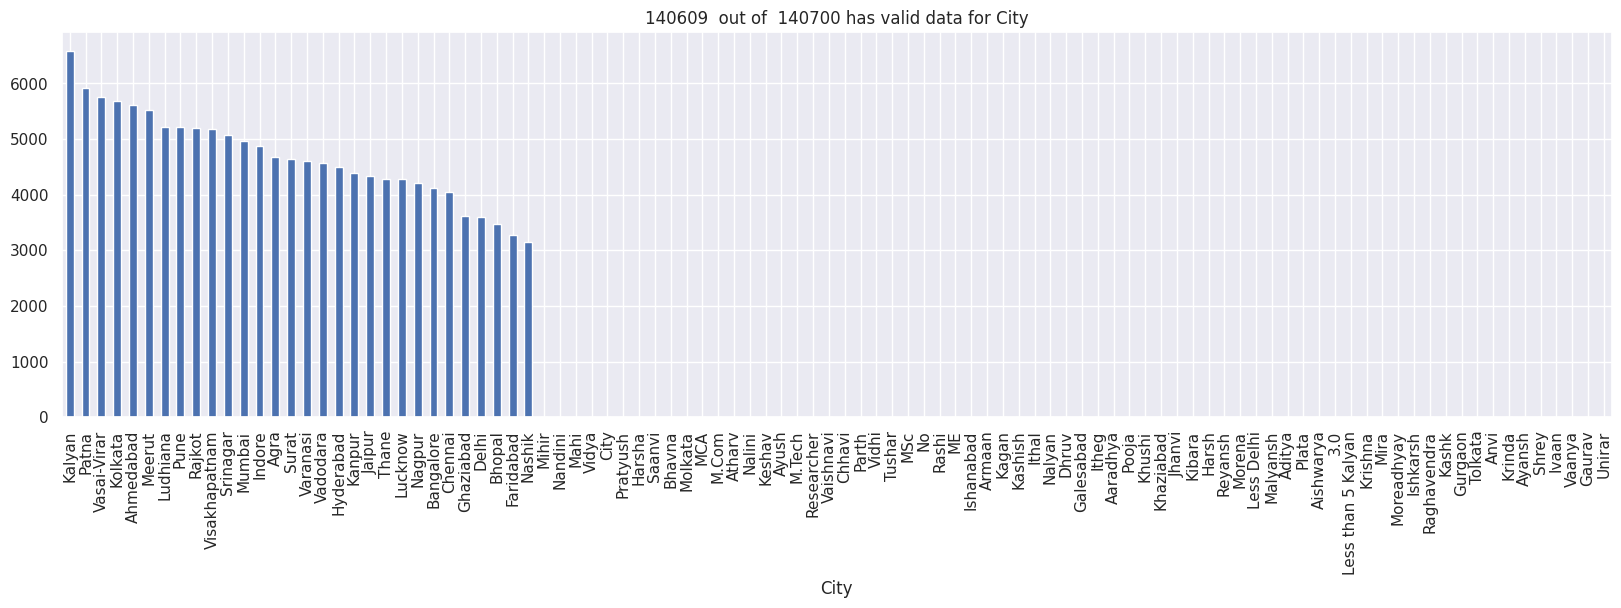

In [10]:
#Bar plots representing the high cardinality categorical features
grps =dsTrain.groupby("Degree").filter(lambda x: len(x) > 5)
heading = f'{len(grps)}  out of  {len(dsTrain)} has valid data for Degree'
fig , ax = plt.subplots(figsize=(20, 5))
dsTrain['Degree'].value_counts().plot(kind='bar', y='Degree', x='count')
plt.title(heading)
plt.show()


grps =dsTrain.groupby("City").filter(lambda x: len(x) > 5)
heading = f'{len(grps)}  out of  {len(dsTrain)} has valid data for City'
fig , ax = plt.subplots(figsize=(20, 5))
dsTrain['City'].value_counts().plot(kind='bar', y='City', x='count')
plt.title(heading)
plt.show()


#Data Preprocessing

---



In [ ]:
''' Feature engineering , didnt help wih accuracy score
import numpy as np
# To merge job statisfaction and Study Satisfaction
#Remove the conflicting job satisfaction column data for ids 1428 and 116703
# as they belong to students and Study satisfaction is enough for modelling

dsTrain.loc[1428, ['Job Satisfaction']] = np.NAN
dsTrain.loc[116703, ['Job Satisfaction']] = np.NAN
#dsTrain['Job Satisfaction']= np.where(((dsTrain['Job Satisfaction'].isnull())&
#                                        (dsTrain['Working Professional or Student']=='Student')),
#                                       dsTrain['Study Satisfaction'], dsTrain['Job Satisfaction'])
dsTrain['Job_Study_Satisfaction']= np.where(dsTrain['Job Satisfaction'].isnull(),
                                         dsTrain['Study Satisfaction'], dsTrain['Job Satisfaction'])


dsTrain.drop(['Study Satisfaction'], axis =1,inplace=True)
dsTrain.drop(['Job Satisfaction'], axis =1,inplace=True)

print(dsTrain[dsTrain['Job_Study_Satisfaction'].isnull()])
CAT_FEATURES.remove('Study Satisfaction')
CAT_FEATURES.remove('Job Satisfaction')
CAT_FEATURES.append('Job_Study_Satisfaction')
'''

In [ ]:
''' Feature engineering , didnt help wih accuracy score
# To merge Academic pressure and Job pressure
print(dsTrain['Academic Pressure'].isnull().sum())
dsTrain['Work_Academic_Pressure'] = np.where(dsTrain['Working Professional or Student']=='Student',
                               dsTrain['Academic Pressure'],dsTrain['Work Pressure'])
print(dsTrain['Academic Pressure'].isnull().sum())
dsTrain.drop(['Work Pressure'], axis =1,inplace=True)
dsTrain.drop(['Academic Pressure'], axis =1,inplace=True)
print(dsTrain[dsTrain['Work_Academic_Pressure'].isnull()])
CAT_FEATURES.remove('Academic Pressure')
CAT_FEATURES.remove('Work Pressure')
CAT_FEATURES.append('Work_Academic_Pressure')'''

In [ ]:
import numpy as np
#3. This function processes and prepares the data ready for ML algorithm
def wrangle(ds):

  dsRet= ds.drop(["id", "Name"], axis= 1)

  #CAT_FEATURES = [col for col in  dsRet.columns if dsRet[col].dtype == object]
  #Convert all categorical features to string
  for feature in CAT_FEATURES:
    dsRet[feature]=dsRet[feature].astype(str)

  return dsRet

processed_Train=wrangle(dsTrain)

#Split the data to train and validation

In [ ]:
#Split train and val data
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

y=processed_Train[TARGET]
X=processed_Train.drop(TARGET, axis = 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=40)


#Train the model with CATBoost

In [ ]:
catFeatureIndices = [X_train.columns.get_loc(col) for col in CAT_FEATURES]
'''ITERATIONS='iterations'
DEPTH = 'depth'
LEARNING_RATE = 'learning_rate'
LOSS_FUNCTION='loss_function'
TRAIN_ACC ='Train_Acc'
TEST_ACC = 'Test_Acc''''

In [ ]:
'''#Since there are many categorical variables with high cardinality CATBoost might be an appropriate choice

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
def CatModelAccuracy(catFeatureIndices, paramGrid) :
#catFeatureIndices = [X_train.columns.get_loc(col) for col in CAT_FEATURES]

  trainingPool = Pool(X_train, label=y_train, cat_features=catFeatureIndices)
  valPool = Pool(X_val, label=y_val,cat_features=catFeatureIndices)

#iterations=100, depth=3, learning_rate=0.1, loss_function='Logloss'
  model = CatBoostClassifier(silent= True,iterations=np.int64(paramGrid[ITERATIONS]), depth=np.int64(paramGrid[DEPTH]),
                             learning_rate=np.float64(paramGrid[LEARNING_RATE]) , loss_function=paramGrid[LOSS_FUNCTION])
  model.fit(trainingPool)

  # predicting for validation data
  y_pred=model.predict(valPool)

  #Accuracy for validation data
  accuracy = accuracy_score(y_val,y_pred)
  print(f"Validation Accuracy: {accuracy:.2f}")
  paramGrid[TEST_ACC] = round(accuracy,2)
  # predicting accuracy
  y_pred_train=model.predict(trainingPool)

  accuracytrain= accuracy_score(y_train,y_pred_train)
  # print accuracy
  print(f"Training Accuracy: {accuracytrain}")
  paramGrid[TRAIN_ACC]= round(accuracytrain,2)'''


In [ ]:
#iterations=100, depth=3, learning_rate=0.1, loss_function='Logloss'
#model = CatBoostClassifier(silent= True,iterations =1000, learning_rate= 0.09168876978765067,
#                           depth= 3, subsample= 0.8483139697862532, colsample_bylevel= 0.19844892291519659, min_data_in_leaf= 26)
#{'learning_rate': 0.02428237258878369, 'depth': 8, 'subsample': 0.9590175081826608, 'colsample_bylevel': 0.5939457491059013, 'min_data_in_leaf': 56}
#model = CatBoostClassifier(silent= True,iterations =1000, learning_rate= 0.02428237258878369,
#                           depth= 8, subsample= 0.9590175081826608, colsample_bylevel= 0.5939457491059013, min_data_in_leaf= 56)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

trainingPool = Pool(X_train, label=y_train, cat_features=catFeatureIndices)
valPool = Pool(X_val, label=y_val,cat_features=catFeatureIndices)

model = CatBoostClassifier(silent= True,iterations =1000, learning_rate= 0.06935994732017255,
                           depth= 6, colsample_bylevel= 0.2388830216292116, min_data_in_leaf= 7)

model.fit(trainingPool)



In [ ]:
# predicting for validation data
print ('Report for testing data')
pred=model.predict(valPool)
report= classification_report(y_val, pred)
print(report)

print ('Report for training data')
pred=model.predict(trainingPool)
report= classification_report(y_train, pred)
print(report)

Report for testing data
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     34474
           1       0.85      0.82      0.83      7736

    accuracy                           0.94     42210
   macro avg       0.90      0.89      0.90     42210
weighted avg       0.94      0.94      0.94     42210

Report for training data
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     80659
           1       0.86      0.83      0.85     17831

    accuracy                           0.95     98490
   macro avg       0.91      0.90      0.91     98490
weighted avg       0.94      0.95      0.94     98490



CatBoostClassifier


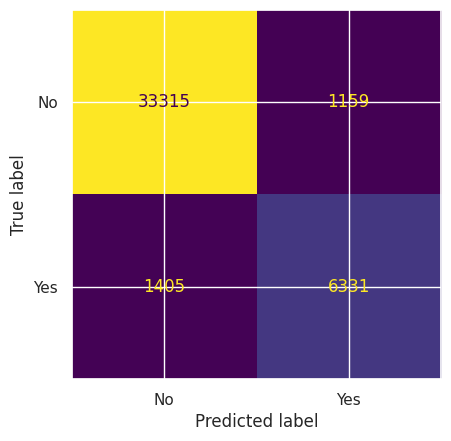

In [ ]:
#Confusion matrix diaplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cmatrix =confusion_matrix(y_val, pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = ['No', 'Yes'])
subplot = cm_display.plot( colorbar=False)
print(type(model).__name__)
plt.show()

In [ ]:
#Function to calculate the auc
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
def calculateROC(model):

  Y_prob=model.predict_proba(X_val)
  fpr, tpr, thresold =roc_curve(y_val, Y_prob[:,1])
  roc_auc=auc(fpr,tpr)
  plt.plot(fpr, tpr, label =f'{type(model)} with roc_auc{roc_auc:.2f}')

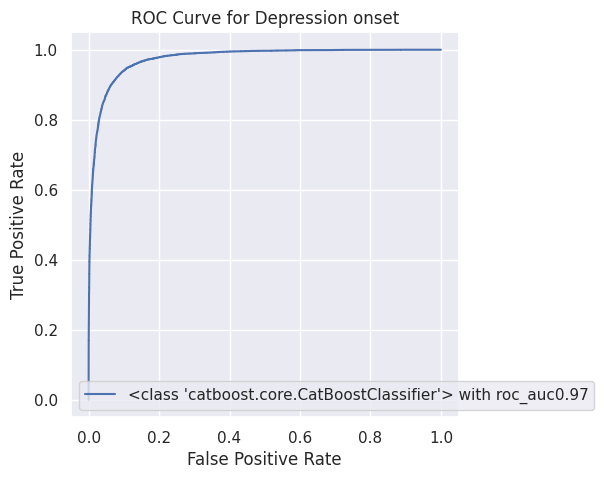

In [ ]:
#5 plot the roc
plt.figure(figsize=(5,5), dpi=100)
calculateROC(model)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Depression onset')
plt.legend()
plt.show()

In [ ]:
'''#this combination is unnecessary , its taken care of by optuna
#Hyperparameter tuning

COLUMN_NAMES = [ITERATIONS,DEPTH,LEARNING_RATE, LOSS_FUNCTION, TRAIN_ACC, TEST_ACC]
data = np.array([[100, 3, 0.001, 'Logloss', np.NAN,np.NAN],
                 [1000, 10, 0.1, 'Logloss', np.NAN,np.NAN]])

                 [100, 4, 0.1, 'Logloss', np.NAN,np.NAN],
                 [300, 3, 0.1, 'Logloss', np.NAN,np.NAN],
                 [300, 4, 0.1, 'Logloss', np.NAN,np.NAN],
                 [300, 5, 0.1, 'Logloss', np.NAN,np.NAN],
                 [500, 3, 0.1, 'Logloss', np.NAN,np.NAN],
                 [500, 4, 0.1, 'Logloss', np.NAN,np.NAN],
                 [500, 5, 0.1, 'Logloss', np.NAN,np.NAN],
                 ])
results=pd.DataFrame(data, columns =COLUMN_NAMES)
for row in range(len(results)):
  paramGrid=pd.Series(results.iloc[row,:], index= results.columns)
  print(paramGrid)
  CatModelAccuracy( catFeatureIndices, paramGrid)
  print(paramGrid)
  results.loc[row,TRAIN_ACC] =paramGrid[TRAIN_ACC]
  results.loc[row,TEST_ACC] = paramGrid[TEST_ACC]
  print(results.iloc[row].to_frame().T)


print(results)'''

#Hyperparameter tunning with Optuna

In [ ]:
#Optuna has a objecctive function and the number of trials involved as param
#A study with the objective is created which focuses on optimizing the
#objective functions return value, which is accracy in this case.
import optuna
from sklearn.metrics import classification_report
def Objective(test):
  params = {
        "iterations": 1000,
        "learning_rate": test.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": test.suggest_int("depth", 1, 10),
        "colsample_bylevel": test.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": test.suggest_int("min_data_in_leaf", 1, 100),
    }
  trainingPool = Pool(X_train, label=y_train, cat_features=catFeatureIndices)
  valPool = Pool(X_val, label=y_val,cat_features=catFeatureIndices)

  catModel= CatBoostClassifier(**params, silent=True)
  catModel.fit(trainingPool)
  pred=catModel.predict(valPool)
  report= classification_report(y_val, pred, output_dict=True)
  f1score=report['0']['f1-score'] #Focus on false nagative
  accuracy = accuracy_score(y_val,pred)
  return accuracy

study = optuna.create_study(directions=['maximize'])
study.optimize(Objective, n_trials=30)

In [ ]:

print('Best hyperparameters:', study.best_params)
print('Best Accuracy:', study.best_value)

#Find the optimal thresold with ROC

In [ ]:
print(model.get_probability_threshold())
model.set_probability_threshold(0.5)
pred=model.predict(valPool)
accuracy = accuracy_score(y_val,pred)
print(round(accuracy*100,2))
pred = model.predict(trainingPool)
accuracy = accuracy_score(y_train,pred)
print("TRainning accuracy", accuracy)

0.5
93.94
TRainning accuracy 0.9464209564422784


#Predict for test data

In [ ]:
import numpy as np
print(dsTest['Academic Pressure'].isnull().sum())
print(dsTest['Work Pressure'].isnull().sum())
print(len(dsTest['Working Professional or Student'].unique()))

#print(dsTest[dsTest['Job Satisfaction'].notnull() &
#        dsTest['Study Satisfaction'].notnull()])

# No merging conflicts with the pressure columns
dsTest[dsTest['Academic Pressure'].notnull() &
        dsTest['Work Pressure'].notnull()]
print(dsTest['Working Professional or Student'].value_counts())
print(len(dsTest[dsTest['Working Professional or Student']=='Student']))
dsTest['Work_Academic_Pressure'] = np.where(dsTest['Working Professional or Student']=='Student',
                               dsTest['Academic Pressure'],dsTest['Work Pressure'])



In [ ]:
#Prediction for test data
processed_Test = wrangle(dsTest)
yPred =model.predict(processed_Test)

[2, 4, 5, 6, 8, 9, 10, 11, 14, 13, 16, 15]
[2, 4, 5, 6, 8, 9, 10, 11, 14, 13, 16, 15]


#predictions in a csv file for submission

In [ ]:
print(len(dsTest['id']), len(yPred))

submission = pd.DataFrame(dsTest['id'])
submission[TARGET]=yPred
submission.to_csv('result.csv',index= False)


93800 93800


#Feature Importance

Age                                      26.550447
Have you ever had suicidal thoughts ?    19.621582
Financial Stress                          8.791154
Work Pressure                             7.186961
Job Satisfaction                          7.026255
Work/Study Hours                          6.472639
Dietary Habits                            4.491141
Academic Pressure                         4.062051
Profession                                3.556640
Sleep Duration                            2.919711
dtype: float64


<Axes: >

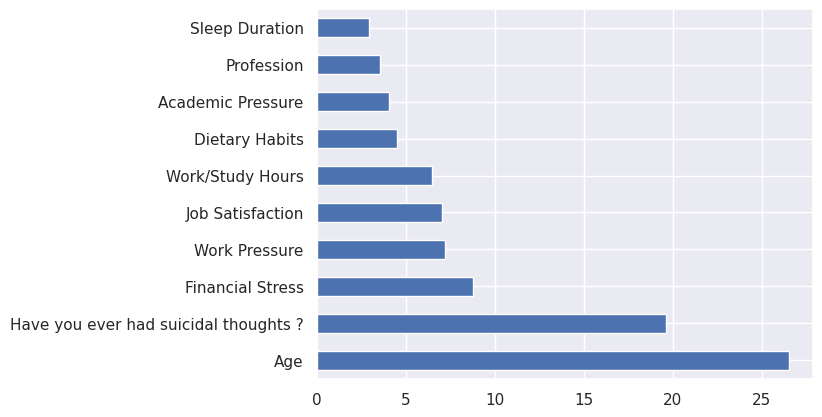

In [ ]:
features = pd.Series(model.feature_importances_, index = X_train.columns)

print(features.nlargest(10))

features.nlargest(10).plot.barh(y=features.index)